In [22]:
import math
import requests

from yaml import safe_load
from typing import Callable
from scipy.stats import sem
from matplotlib import pyplot

## Configuration

In [23]:
# Retrieve configuration file for elastic
with open("../debug.config.yml") as config:
    config_file = safe_load(config)["backend"]

## Evaluation

### Setup

In [24]:
class Options:
    def __init__(self, r_min: int=10, r_max: int=100, step: int=10, reps: int=5):
        self.r_min = r_min
        self.r_max = r_max
        self.step = step
        self.reps = reps
        
evaluations: dict[str, dict[str, dict[str, list[int] | list[float]]]] = {}

colors_map: dict[str, str] = {
    "metadata": "orange",
    "specification": "royalblue",
    "both": "forestgreen"
}

In [25]:
def perform_search_query(query: str|None, fields: list[str], size:int = 10, k: int|None=100) -> int:
    k_param: str = f"&k={k}" if k else ""
    url: str = f"http://localhost:{config_file['port']}/api/v1/search?size={size}{k_param}"
    body: dict[str, str|list[str]] = {
        "fields": fields
    }
    
    if query: body["fragment"] = query
    response = requests.post(url, json=body)
    
    return round(response.elapsed.microseconds / 1000)

In [26]:
def get_random_query() -> str:
    return " ".join(requests.get("https://random-word-api.herokuapp.com/word?lang=en&number=3").json())

### Tests

In [27]:
def no_queries_test(fields: list[str]=None, size: int=None, k: int=None) -> int:
    return perform_search_query(None, fields, size, None)

In [28]:
def random_queries_test(fields: list[str]=None, size: int=None, k: int=None) -> int:
    return perform_search_query(get_random_query(), fields, size, k)

In [29]:
def run_test(test: Callable[[list[str], int, int], int], options: Options, debug=False):
    global evaluations
    
    cases: list[list[str]] = [["metadata"], ["specification"], ["metadata", "specification"]]
    
    if debug: print(f"{test.__name__}:")
    
    for idx, case in enumerate(cases):
        times: list[int] = []
        errs: list[float] = []
        
        if debug: print(f"\t{case}", end=": [")
        
        for i in range(options.r_min, options.r_max+1, options.step):
            tmp_times: list[int] = []
            
            for _ in range(options.reps):
                tmp_times.append(test(case, i, i))
            
            times.append(round(sum(tmp_times)/options.reps))
            errs.append(sem(tmp_times))
            
            if debug: print(f"{round(sum(tmp_times)/options.reps)}", end=", " if i != options.r_max else "")
            
        if debug: print("]")
        
        if test.__name__ not in evaluations:
            evaluations[test.__name__] = {}
            
        case_name = case[0] if idx != 2 else "both"
        
        if case_name not in evaluations[test.__name__]:
            evaluations[test.__name__][case_name] = {}
        
        evaluations[test.__name__][case_name]["ys"] = times
        evaluations[test.__name__][case_name]["errs"] = errs
        
    if debug: print()

### Results


In [33]:
def display_graph(options: Options):
    global evaluations
    
    x = [i for i in range(options.r_min, options.r_max+1, options.step)]
    
    fig, axes = pyplot.subplots(math.ceil(len(evaluations.keys())/2), 2, figsize=(10, 4))
    fig.suptitle("Performance test @K")
    
    for idx, (test, results) in enumerate(evaluations.items()):
        position_bin: str = bin(idx).replace("0b", "")
        position: list[int] = [0, int(position_bin)] if len(position_bin) == 1 else [int(position_bin[0]), int(position_bin[1])]
        
        for case, item in results.items():
            axes[position[1]].errorbar([str(x_i) for x_i in x], item["ys"], item["errs"], fmt='o', linewidth=2, capsize=6, label=case, color=colors_map[case])
            # axes[position[1]].plot(x, item["ys"])
            
        all_ys = [y for case in evaluations.values() for el in case.values() for y in el["ys"]]
        max_val = max(all_ys)
            
        axes[position[1]].set_title(test.replace("_", " ").replace("test", ""))
        axes[position[1]].legend(loc="upper left")
        axes[position[1]].set_xlabel("Number of documents (K)")
        axes[position[1]].set_ylabel("Retrieval time (in ms)")
        axes[position[1]].set_ylim(0, max_val+50)
        
    fig.tight_layout(h_pad=1)
    pyplot.savefig("out.pdf")

In [31]:
opts: Options = Options(reps=10, r_max=120)

run_test(no_queries_test, opts, debug=True)
run_test(random_queries_test, opts, debug=True)

no_queries_test:
	['metadata']: [56, 80, 140, 163, 199, 276, 245, 318, 356, 356, 403, 390]
	['specification']: [62, 79, 137, 212, 242, 296, 325, 354, 407, 382, 432, 419]
	['metadata', 'specification']: [60, 85, 134, 235, 255, 260, 314, 358, 381, 410, 400, 441]

random_queries_test:
	['metadata']: [49, 70, 99, 127, 146, 177, 212, 254, 224, 289, 289, 343]
	['specification']: [54, 89, 124, 135, 162, 192, 245, 255, 290, 283, 341, 394]
	['metadata', 'specification']: [51, 87, 111, 151, 158, 220, 228, 228, 283, 326, 356, 346]



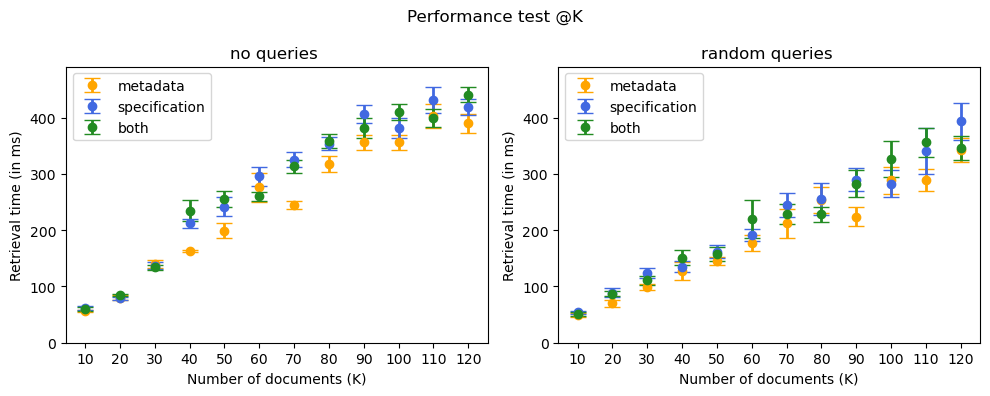

In [34]:
display_graph(opts)

In [39]:
no_meta = [56, 80, 140, 163, 199, 276, 245, 318, 356, 356, 403, 390]
no_spec = [62, 79, 137, 212, 242, 296, 325, 354, 407, 382, 432, 419]
no_meta_spec = [60, 85, 134, 235, 255, 260, 314, 358, 381, 410, 400, 441]
# [59.3, 81.3, 137, 203.3, 232, 277.3, 294.6, 343.3, 381.3, 382.6, 411.6, 416.6]

rand_meta = [49, 70, 99, 127, 146, 177, 212, 254, 224, 289, 289, 343]
rand_spec = [54, 89, 124, 135, 162, 192, 245, 255, 290, 283, 341, 394]
rand_meta_spec = [51, 87, 111, 151, 158, 220, 228, 228, 283, 326, 356, 346]
# [51.3, 82.0, 111.3, 137.6, 155.3, 196.3, 228.3, 245.6, 265.6, 299.3, 328.6, 361]

no_means = [(x+y+z)/3 for (x, y, z) in zip(no_meta, no_spec, no_meta_spec)]
rand_means = [(x+y+z)/3 for (x, y, z) in zip(rand_meta, rand_spec, rand_meta_spec)]